In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
#Set Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
DATA_PATH = "../data/Train.csv" 

In [4]:
# Problem Statement
print("""
PROBLEM STATEMENT:
Customer Churn Prediction for Telecom Company

IMPORTANCE:
- Customer churn directly impacts revenue and profitability
- Acquiring new customers is 5-25x more expensive than retaining existing ones
- Proactive retention strategies can save significant costs
- Helps in targeted marketing and personalized offers

ML MODEL BENEFITS:
- Identify at-risk customers before they leave
- Enable proactive retention campaigns
- Reduce churn rate by 20-30%
- Increase customer lifetime value
- Optimize marketing spend by targeting right customers
""")


PROBLEM STATEMENT:
Customer Churn Prediction for Telecom Company

IMPORTANCE:
- Customer churn directly impacts revenue and profitability
- Acquiring new customers is 5-25x more expensive than retaining existing ones
- Proactive retention strategies can save significant costs
- Helps in targeted marketing and personalized offers

ML MODEL BENEFITS:
- Identify at-risk customers before they leave
- Enable proactive retention campaigns
- Reduce churn rate by 20-30%
- Increase customer lifetime value
- Optimize marketing spend by targeting right customers



<h2>Load Data and Initial Exploration</h2>

In [3]:
# Load the data
df = pd.read_csv(DATA_PATH) 

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData head")
print(df.head())


print(f"\nTarget distribution:\n{df['CHURN'].value_counts()}")
print(f"Churn rate: {(df['CHURN'].mean() * 100):.2f}%")

Dataset shape: (2154048, 19)

Columns: ['user_id', 'REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2', 'MRG', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK', 'CHURN']

Data head
                                    user_id  REGION         TENURE  MONTANT  \
0  00000bfd7d50f01092811bc0c8d7b0d6fe7c3596  FATICK   K > 24 month   4250.0   
1  00000cb4a5d760de88fecb38e2f71b7bec52e834     NaN  I 18-21 month      NaN   
2  00001654a9d9f96303d9969d0a4a851714a4bb57     NaN   K > 24 month   3600.0   
3  00001dd6fa45f7ba044bd5d84937be464ce78ac2   DAKAR   K > 24 month  13500.0   
4  000028d9e13a595abe061f9b58f3d76ab907850f   DAKAR   K > 24 month   1000.0   

   FREQUENCE_RECH  REVENUE  ARPU_SEGMENT  FREQUENCE  DATA_VOLUME  ON_NET  \
0            15.0   4251.0        1417.0       17.0          4.0   388.0   
1             NaN      NaN           NaN        NaN          NaN     NaN   
2             2.0   1020.0

# Telecom Customer Dataset - Column Descriptions and Notes on Data

## Customer Unique Identification Id
- **user_id**: Unique identifier for each customer (hashed/encoded for privacy)
  - Type: String (Categorical)
  - Usage: Can be removed .. No info to predict churn

## Geographic Information
- **REGION**: Geographic region where the customer is located
  - Type: Categorical (e.g., FATICK, DAKAR)
  - Importance: Location of user is important as it tells about network coverage
  -  Some locations might have higher churn due to network coverage issues


## Duration of Relation
- **TENURE**: Customer relationship duration with the company
  - Type: Categorical 
  - Values: "I 18-21 month", "K > 24 month"(have convert to ordinal - avg/high/low)
  - Importance: Long-term customers typically have lower churn rates

## Financial Spending Patterns
- **MONTANT**: Top-up amount or recharge amount (in local currency)
  - Type: Numerical (Continuous)
  - Importance: tells about customer's spending behavior

- **REVENUE**: Total revenue generated from the customer
  - Type: Numerical (Continuous)
  - Importance: Direct measure of customer value to the business
  - Correlation: High-revenue customers are typically retained better

- **ARPU_SEGMENT**: Average Revenue Per User segment
  - Type: Numerical (Continuous)
  - Importance: Customer value segmentation
  - Business Use: Helps in identifying high-value customers for retention

## Usage Behavior & Patterns
- **FREQUENCE_RECH**: Recharge frequency
  - Type: Numerical (Discrete)
  - Importance: How often customer tops up their account
  - Churn Signal: Decreasing frequency may indicate disengagement

- **FREQUENCE**: Overall usage frequency
  - Type: Numerical (Discrete)
  - Importance: How actively the customer uses services
  - Business Insight: Low frequency might predict churn

- **DATA_VOLUME**: Amount of data consumed
  - Type: Numerical (Continuous)
  - Importance: Data usage pattern indicator
  - Trend: Increasing data users are less likely to churn

## Network Usage & Call Patterns to itself and different competitors (ORANGE, TIGO)
- **ON_NET**: Calls within the same network
  - Type: Numerical (Continuous)
  - Importance: Indicator of their circle network

- **ORANGE**: Calls to Orange network
  - Type: Numerical (Continuous)
  - Importance: Cross-network calling pattern (high value indicated their circle using more Orange)

- **TIGO**: Calls to Tigo network
  - Type: Numerical (Continuous)
  - Importance: Another competitor network usage
  - Pattern: '''

## Geographic Usage Patterns
- **ZONE1**: Usage in zone 1 (likely primary zone)
  - Type: Numerical (Continuous)
  - Importance: Geographic usage concentration

- **ZONE2**: Usage in zone 2 (likely secondary zone)
  - Type: Numerical (Continuous)
  - Importance: Secondary geographic usage

## Service Plan & Package Information
- **MRG**: Marketing segment or customer group
  - Type: Categorical (e.g., "NO")
  - Importance: Customer segmentation for marketing
  - Business Use: Targeted marketing campaigns

- **TOP_PACK**: The top package used by customer
  - Type: Categorical (e.g., "On net 200F=Unlimited_call24H")
  - Importance: Service plan preference 
  - Churn Signal: Tells about satisfiction to the package

- **FREQ_TOP_PACK**: Frequency of using the top package
  - Type: Numerical (Continuous)
  - Importance: How actively the customer uses their main package

## Customer Behavior Metrics
- **REGULARITY**: How regular the customer usage is
  - Type: Numerical (Continuous)
  - Importance: Consistency of service usage

## Target Variable
- **CHURN**: Customer churn status
  - Type: Binary (0 = Active, 1 = Churned)
  - Importance: Target variable for prediction

## Data Quality Notes
- **Missing Values**: Several columns have significant missing data
- **Scale Variations**: Numerical features have different scales and distributions
- **Categorical Encoding**: Multiple categorical variables need preprocessing
- **Business Context**: Understanding telecom operations helps interpret feature importance and underlying linear combinations of given features which makes more sense to churn prediction

In [9]:
df['ARPU_SEGMENT'].value_counts()

ARPU_SEGMENT
167.0      67878
333.0      43705
500.0      28568
667.0      22898
67.0       22753
           ...  
13981.0        1
15615.0        1
16822.0        1
22563.0        1
16786.0        1
Name: count, Length: 16535, dtype: int64

### Data Types, missing values summary

In [10]:
# Display data types summary
print("\nData Types Summary:")
print(df.dtypes.value_counts())

# Check for missing values
print("\nMissing Values by Column:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percent': missing_percent
}).sort_values('Missing_Count', ascending=False)
print(missing_summary[missing_summary['Missing_Count'] > 0])


Data Types Summary:
float64    12
object      5
int64       2
Name: count, dtype: int64

Missing Values by Column:
                Missing_Count  Missing_Percent
ZONE2                 2017224        93.648052
ZONE1                 1984327        92.120835
TIGO                  1290016        59.887988
DATA_VOLUME           1060433        49.229776
TOP_PACK               902594        41.902223
FREQ_TOP_PACK          902594        41.902223
ORANGE                 895248        41.561191
REGION                 849299        39.428044
ON_NET                 786675        36.520774
MONTANT                756739        35.131018
FREQUENCE_RECH         756739        35.131018
FREQUENCE              726048        33.706213
ARPU_SEGMENT           726048        33.706213
REVENUE                726048        33.706213


### Target distribution

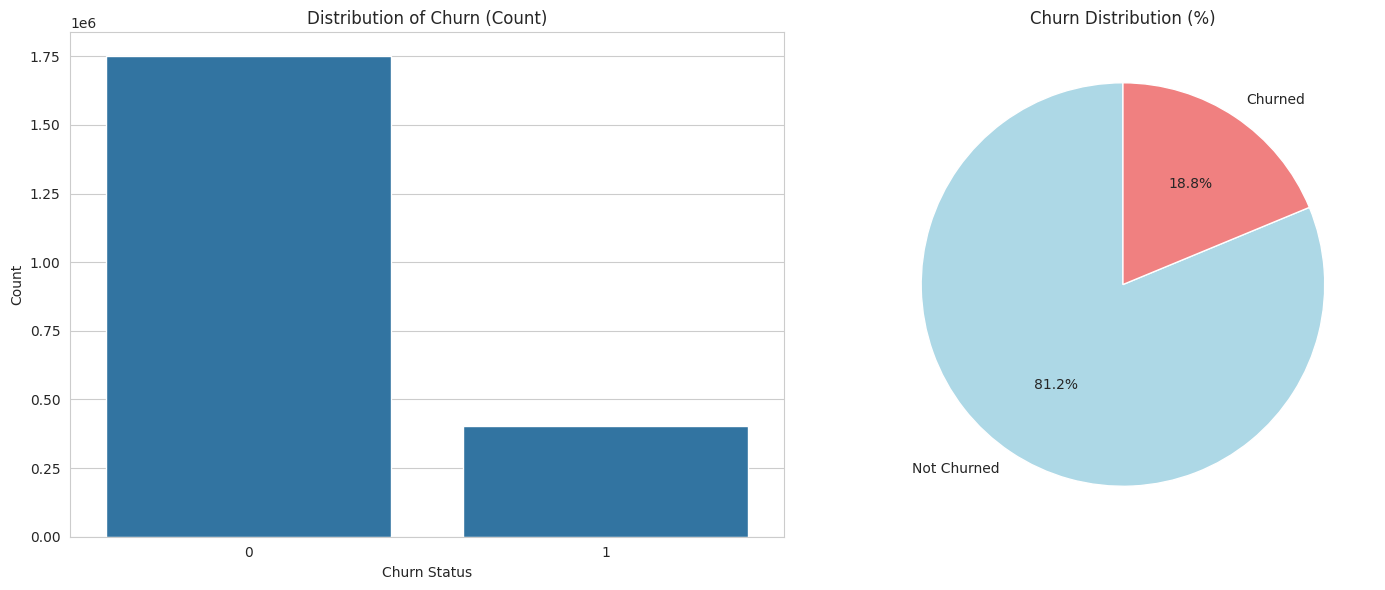

Churn Rate Statistics:
Total customers: 2154048
Churned customers: 403986
Churn rate: 18.75%


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
sns.countplot(data=df, x='CHURN', ax=axes[0])
axes[0].set_title('Distribution of Churn (Count)')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Count')

# Pie chart
churn_counts = df['CHURN'].value_counts()
axes[1].pie(churn_counts.values, labels=['Not Churned', 'Churned'], 
           autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
axes[1].set_title('Churn Distribution (%)')

plt.tight_layout()
plt.show()

# Print churn statistics
print("Churn Rate Statistics:")
print(f"Total customers: {len(df)}")
print(f"Churned customers: {df['CHURN'].sum()}")
print(f"Churn rate: {(df['CHURN'].sum() / len(df)) * 100:.2f}%")

### Key Numerical Features Distribution

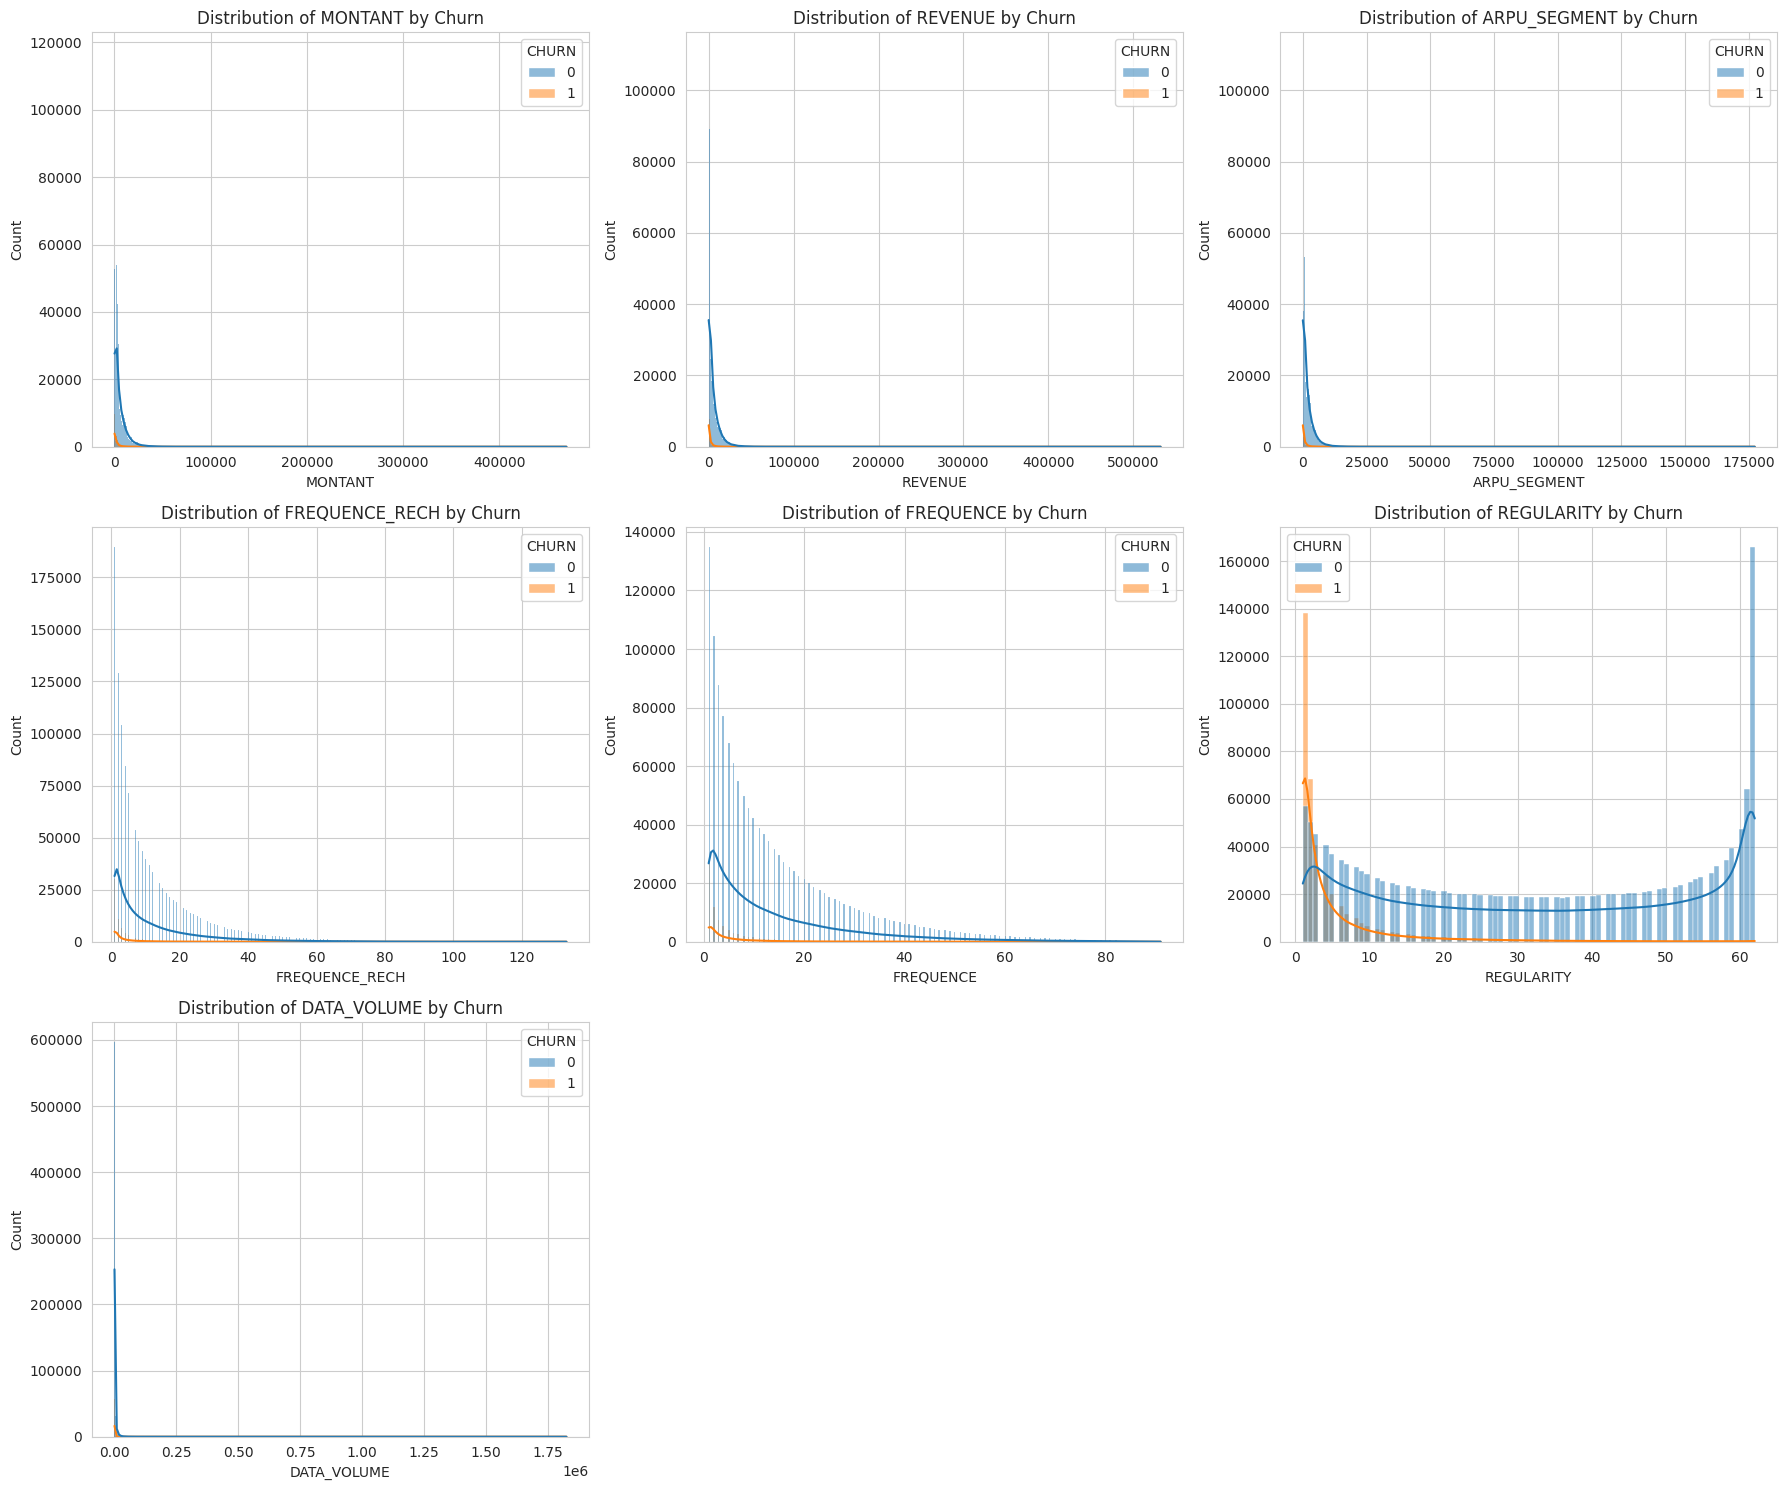

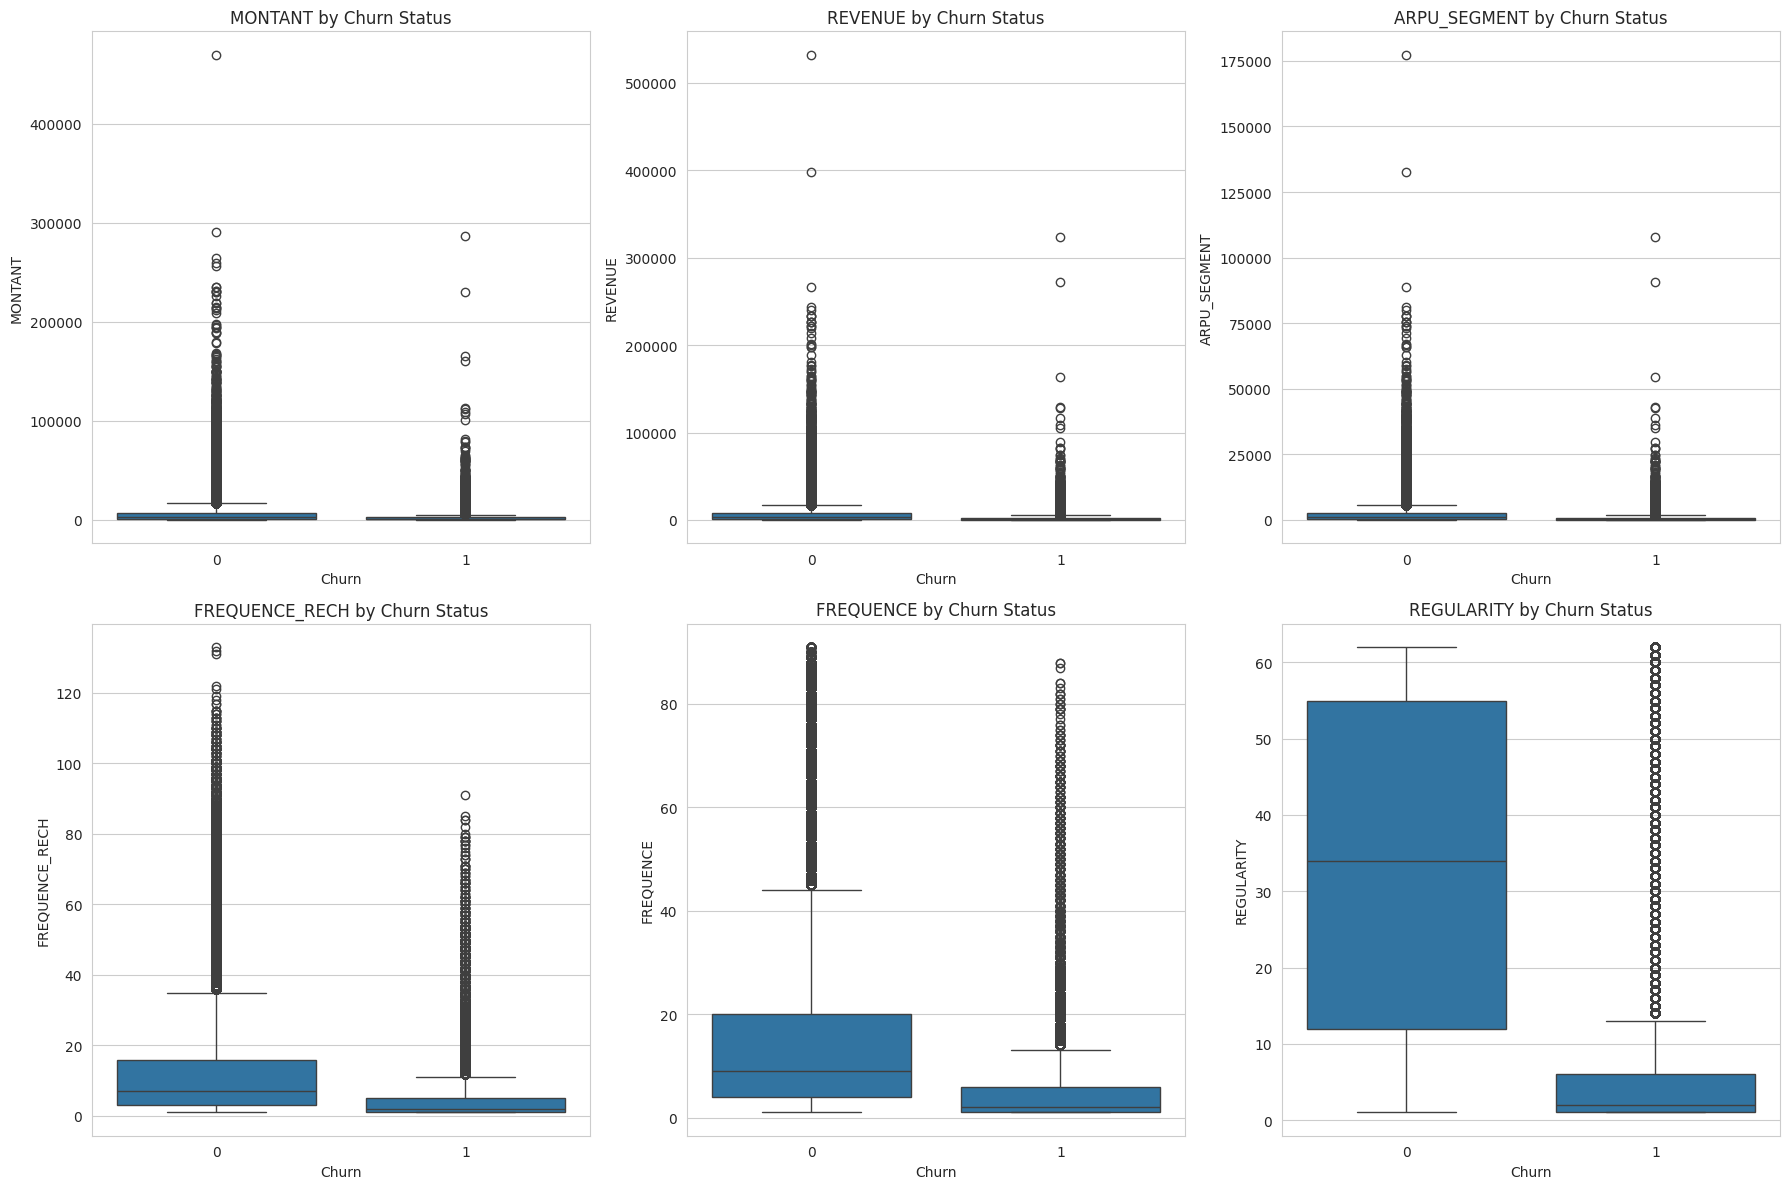

In [12]:
numerical_features = ['MONTANT', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE_RECH', 
                     'FREQUENCE', 'REGULARITY', 'DATA_VOLUME']

# Create distribution plots for numerical features
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for i, feature in enumerate(numerical_features[:9]):
    if feature in df.columns:
        sns.histplot(data=df, x=feature, hue='CHURN', kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature} by Churn')
        axes[i].set_xlabel(feature)


for j in range(len(numerical_features), 9):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(numerical_features[:6]):
    sns.boxplot(data=df, x='CHURN', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} by Churn Status')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

### Categorical Features Analysis

<Figure size 1200x600 with 0 Axes>

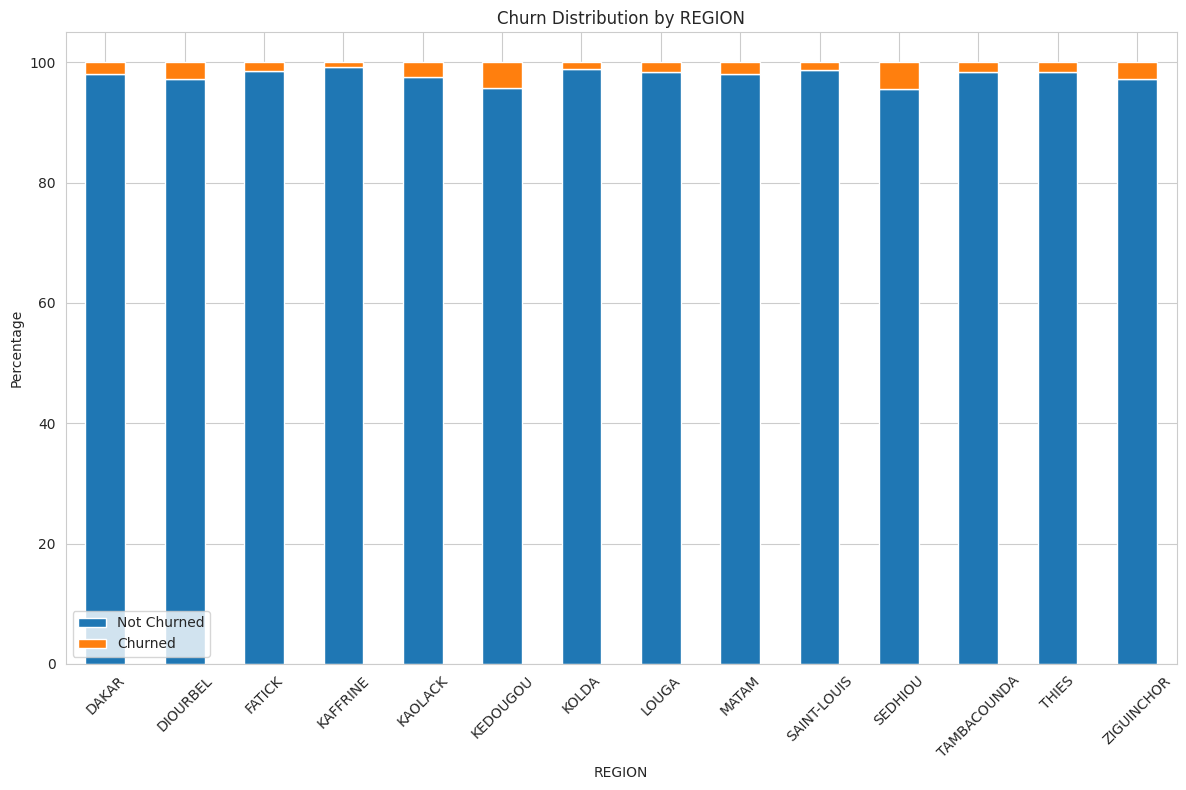


Churn Rates by REGION:
REGION
SEDHIOU        0.043604
KEDOUGOU       0.042157
DIOURBEL       0.028097
ZIGUINCHOR     0.027432
KAOLACK        0.023436
MATAM          0.020080
DAKAR          0.019235
THIES          0.016301
LOUGA          0.015951
TAMBACOUNDA    0.015361
FATICK         0.014196
SAINT-LOUIS    0.012679
KOLDA          0.010763
KAFFRINE       0.007188
Name: CHURN, dtype: float64


<Figure size 1200x600 with 0 Axes>

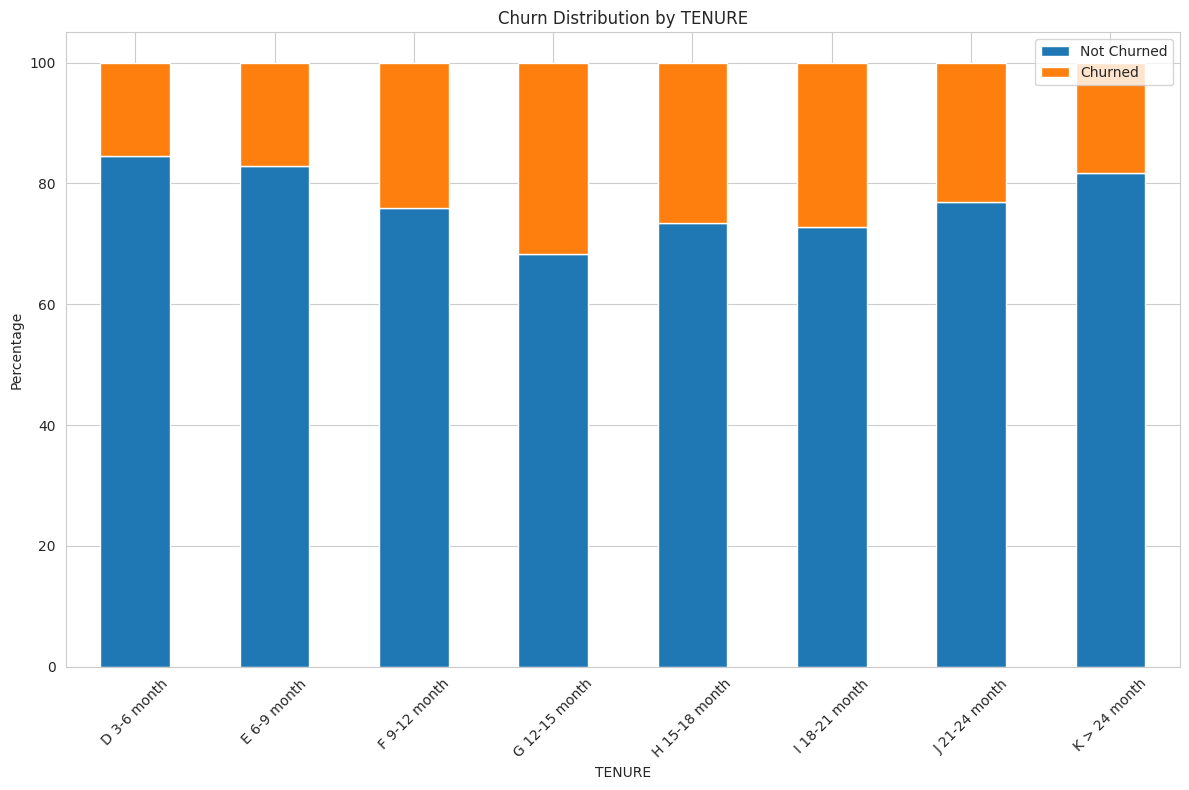


Churn Rates by TENURE:
TENURE
G 12-15 month    0.316287
I 18-21 month    0.272693
H 15-18 month    0.266246
F 9-12 month     0.240137
J 21-24 month    0.230884
K > 24 month     0.183236
E 6-9 month      0.171833
D 3-6 month      0.154545
Name: CHURN, dtype: float64


<Figure size 1200x600 with 0 Axes>

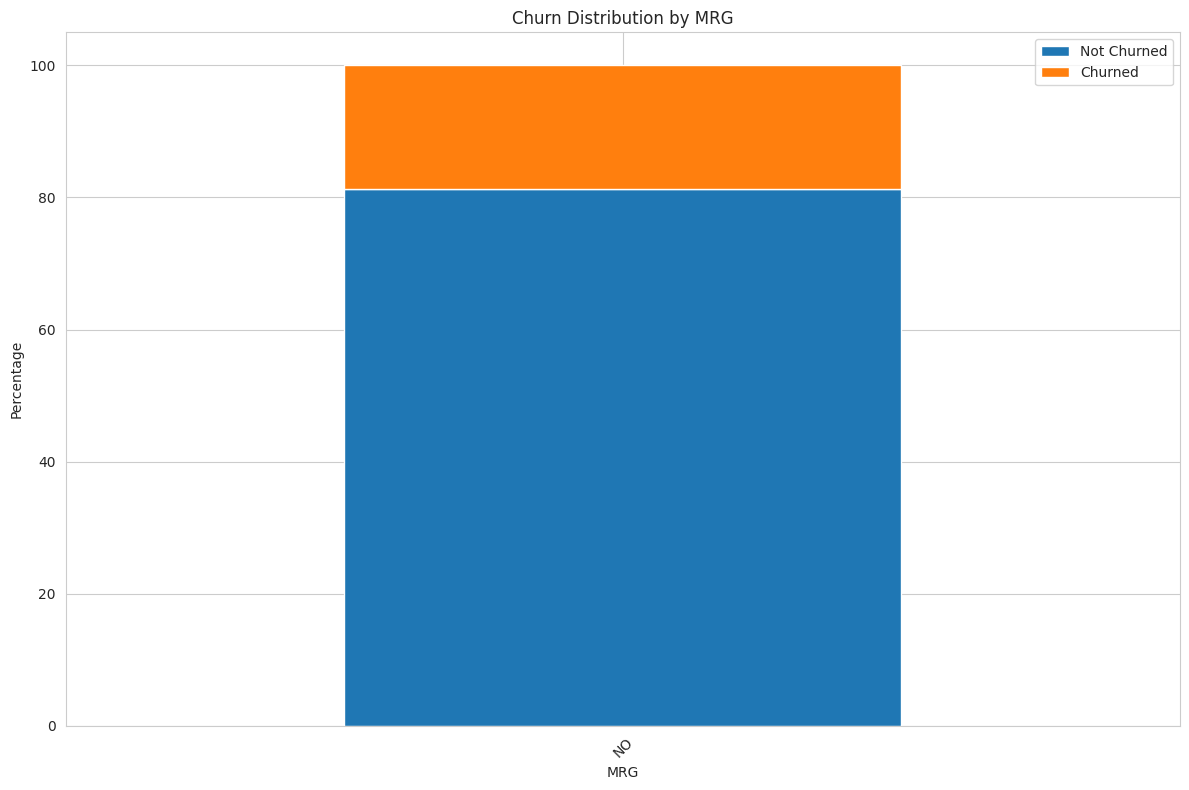


Churn Rates by MRG:
MRG
NO    0.187547
Name: CHURN, dtype: float64


In [13]:
# Categorical features analysis
categorical_features = ['REGION', 'TENURE', 'MRG']

# Create visualizations for categorical features
for feature in categorical_features:
    if feature in df.columns:
        plt.figure(figsize=(12, 6))
        
        # Create cross tabulation
        cross_tab = pd.crosstab(df[feature], df['CHURN'], normalize='index') * 100
        cross_tab.plot(kind='bar', stacked=True)
        plt.title(f'Churn Distribution by {feature}')
        plt.xlabel(feature)
        plt.ylabel('Percentage')
        plt.legend(['Not Churned', 'Churned'])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Print churn rates by category
        print(f"\nChurn Rates by {feature}:")
        churn_rates = df.groupby(feature)['CHURN'].mean().sort_values(ascending=False)
        print(churn_rates)

# DATA PREPROCESSING

### Drop Columns

In [4]:
df.drop('user_id', axis=1, inplace=True) # Just a unique Identifier

In [5]:
df.drop('MRG', axis=1, inplace=True) # All data points have the same value

### Transforming Column "TENURE" into numerical values

In [7]:
df['TENURE'].value_counts()

TENURE
K > 24 month     2043201
I 18-21 month      45278
H 15-18 month      26006
G 12-15 month      14901
J 21-24 month      12725
F 9-12 month        9328
E 6-9 month         1839
D 3-6 month          770
Name: count, dtype: int64

In [6]:
mapping_dict = {'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 'G 12-15 month': 12, 'J 21-24 month': 21, 'F 9-12 month': 9, 'E 6-9 month': 6, 'D 3-6 month': 3}
df['TENURE'] = df["TENURE"].apply(lambda x: mapping_dict[x])

# Handpiked Derived Features - Based on some domain knowledge and intuition

## 1) Data Completeness

- **Null Value_counts** 
  What: Total missing values per customer.
  Why it matters: lots of blanks usually = low engagement.  


## 2) Customer Value & Spending
- **REVENUE_PER_FREQUENCE**  
  What: revenue per usage event → `REVENUE / FREQUENCE`.  

- **SPENDING_CONSISTENCY**  
  What: top-up vs revenue → `MONTANT / REVENUE`.  

- **HIGH_VALUE_CUSTOMER**  
  What: flag if above median `ARPU_SEGMENT`.  

- **SPENDING_PATTERN**  
  What: avg top-up per recharge → `MONTANT / FREQUENCE_RECH`.  


## 3) Usage & Engagement
- **ENGAGEMENT_SCORE**  
  What: simple blend of `recharge + usage frequency`.  

- **USAGE_DECLINE**  
  What: flag when `recharge freq < usage freq`.  

-  **UNLIMITED_PACK**
  what: flag when TOP_PACK" Contains the substring "unlimited"

- **POPULAR PACK**
  what: 0: first quartile (x < 25)
        1: second quartile (25 < x < 50)
        2: third quartile (50 < x < 75)
        3: fourth quartile (75 < x)
        **Quartiles** of the value_counts of TOP_PACK column
        We expect users of popular packages  


In [9]:
original_columns = df.columns.tolist()
print("Original Columns:", original_columns)
# Numerical Features with highest feature importance (XgBoost)
num_features_high = ['REGULARITY', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE_RECH', 'MONTANT', 'ON_NET']
num_features_all = df.select_dtypes(include=["number"]).columns.tolist()
num_features_all.remove("CHURN")

Original Columns: ['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK', 'CHURN']


In [ ]:




def create_derived_features(df):
  #null counts
  df["NULL_COUNTS"] = df.isna().sum(axis=1)

  #revenue per frequency
  df['REVENUE_PER_FREQUENCE'] = df['REVENUE'] / (df['FREQUENCE'] + 1)

  #spending consistency
  df['SPENDING_CONSISTENCY'] = df['MONTANT'] / (df['REVENUE'] + 1)

  #high value customer
  df['HIGH_VALUE_CUSTOMER'] = (df['ARPU_SEGMENT'] > df['ARPU_SEGMENT'].median()).astype(int)

  #spending pattern
  df['SPENDING_PATTERN'] = df['MONTANT'] / (df['FREQUENCE_RECH'] + 1)

  # Engagement score
  df['ENGAGEMENT_SCORE'] = (df['FREQUENCE_RECH'] + df['FREQUENCE']) / 2 

  #usage decline
  df['USAGE_DECLINE'] = (df['FREQUENCE_RECH'] < df['FREQUENCE']).astype(int)


  # unlimited pack user
  df['UNLIMITED_PACK'] = 0
  df.loc[df['TOP_PACK'].str.contains("unlimited", case=False, na=False), 'UNLIMITED_PACK'] = 1

  # popular pack
  low = df['TOP_PACK'].value_counts().describe()["25%"]
  mid = df['TOP_PACK'].value_counts().describe()["50%"]
  high = df['TOP_PACK'].value_counts().describe()["75%"]

  val_counts = df['TOP_PACK'].value_counts()

  def pack_pop(pack):
    if pack is np.nan:
      return -1

    val = val_counts[pack]

    if val < low:
      return 1
    elif val < mid:
      return 2
    elif val < high:
      return 3
    else:
      return 4

  df["PACK_POP"] = df['TOP_PACK'].apply(pack_pop)


  manual_derived_columns = ['NULL_COUNTS', 'REVENUE_PER_FREQUENCE', 'SPENDING_CONSISTENCY',
                            'HIGH_VALUE_CUSTOMER', 'SPENDING_PATTERN', 'ENGAGEMENT_SCORE',
                            'USAGE_DECLINE', 'UNLIMITED_PACK', 'PACK_POP']
  return df, manual_derived_columns

Original Columns: ['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'ZONE1', 'ZONE2', 'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK', 'CHURN']


In [ ]:
df, manual_derived_columns = create_derived_features(df)

In [15]:
df.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,...,CHURN,NULL_COUNTS,REVENUE_PER_FREQUENCE,SPENDING_CONSISTENCY,HIGH_VALUE_CUSTOMER,SPENDING_PATTERN,ENGAGEMENT_SCORE,USAGE_DECLINE,UNLIMITED_PACK,PACK_POP
0,FATICK,24,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,...,0,0,236.166667,0.999530,1,265.625,16.0,1,1,4
1,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,14,NaN,NaN,0,NaN,NaN,0,0,-1
2,NaN,24,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,...,0,4,340.000000,3.525955,0,1200.000,2.0,0,0,4
3,DAKAR,24,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,...,0,2,710.631579,0.999778,1,843.750,16.5,1,0,4
4,DAKAR,24,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,...,0,4,492.500000,1.014199,0,500.000,1.0,0,1,4


## Numerical Feature Brute Forcing

1. **Log transform of each numerical feature**
2. **Region-Wise feature means of all numerical features**
3. **Interaction(+, -, *, /) between *High Importance Features***

In [7]:
def brute_force_features(df, feature_list_all, feature_list_high):
  data = df.copy()
  n = len(feature_list_high)
  epsilon = 1e-6

  # Grouping by Region
  region_groups = data[feature_list_all + ['REGION']].groupby("REGION").mean()
  for feature in feature_list_all:
    feature_name = "REGION_MEAN_" + feature
    region_groups[feature_name] = region_groups[feature]
    region_groups.drop(feature, axis=1, inplace=True)

  data = pd.merge(data, region_groups, on='REGION', how='left')


  # log features
  for feature in feature_list_all:
    feature_name = 'log(' + feature + ")"
    data[feature_name] = np.log(data[feature] + epsilon)

  # Cross Features
  for i in range(n-1):
    for j in range(i+1, n):
      feature_add = feature_list_high[i] + "+" + feature_list_high[j]
      feature_sub = feature_list_high[i] + "-" + feature_list_high[j]
      feature_mult = feature_list_high[i] + "*" + feature_list_high[j]
      feature_div = feature_list_high[i] + "/" + feature_list_high[j]

      data[feature_add] = data[feature_list_high[i]] + data[feature_list_high[j]]
      data[feature_sub] = data[feature_list_high[i]] - data[feature_list_high[j]]
      data[feature_mult] = data[feature_list_high[i]] * data[feature_list_high[j]]
      data[feature_div] = data[feature_list_high[i]] / (data[feature_list_high[j]] + epsilon)

  return data


In [10]:
data = brute_force_features(df, num_features_all, num_features_high)

In [11]:
data.head()

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,...,FREQUENCE_RECH*MONTANT,FREQUENCE_RECH/MONTANT,FREQUENCE_RECH+ON_NET,FREQUENCE_RECH-ON_NET,FREQUENCE_RECH*ON_NET,FREQUENCE_RECH/ON_NET,MONTANT+ON_NET,MONTANT-ON_NET,MONTANT*ON_NET,MONTANT/ON_NET
0,FATICK,24,4250.0,15.0,4251.0,1417.0,17.0,4.0,388.0,46.0,...,63750.0,0.003529,403.0,-373.0,5820.0,0.038660,4638.0,3862.0,1649000.0,10.953608
1,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,24,3600.0,2.0,1020.0,340.0,2.0,NaN,90.0,46.0,...,7200.0,0.000556,92.0,-88.0,180.0,0.022222,3690.0,3510.0,324000.0,40.000000
3,DAKAR,24,13500.0,15.0,13502.0,4501.0,18.0,43804.0,41.0,102.0,...,202500.0,0.001111,56.0,-26.0,615.0,0.365854,13541.0,13459.0,553500.0,329.268285
4,DAKAR,24,1000.0,1.0,985.0,328.0,1.0,NaN,39.0,24.0,...,1000.0,0.001000,40.0,-38.0,39.0,0.025641,1039.0,961.0,39000.0,25.641025


In [17]:
X = data.drop('CHURN', axis=1)
y = data['CHURN']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

: 

# Model 1: Logistic Regression with Embedded Processing

In [ ]:
# Define preprocessing for different data types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])),
    ('feature_selector', SelectKBest(score_func=f_classif, k=20)),
    ('classifier', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])

# Parameter grid for Logistic Regression:cite[8]
lr_param_grid = {
    'feature_selector__k': [25, 30, 40, 50, 60],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# GridSearchCV for Logistic Regression:cite[1]
lr_grid = GridSearchCV(lr_pipeline, lr_param_grid, cv=StratifiedKFold(5), 
                      scoring='roc_auc', n_jobs=1, verbose=1)
lr_grid.fit(X_train, y_train)

# Model 2: Random Forest

In [ ]:
# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])),
    ('feature_selector', RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=20)),
    ('classifier', RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced'))
])

# Parameter grid for Random Forest:cite[3]:cite[6]
rf_param_grid = {
    'feature_selector__n_features_to_select': [25, 30, 40, 50, 60],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=StratifiedKFold(5), 
                      scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

# Model 3: K-Nearest Neighbors with Simple Imputation

In [ ]:

knn_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])),
    ('feature_selector', SelectKBest(score_func=f_classif, k=15)),
    ('classifier', KNeighborsClassifier())
])

# Parameter grid for KNN
knn_param_grid = {
    'feature_selector__k': [25, 30, 40, 50, 60],
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=StratifiedKFold(5), 
                       scoring='roc_auc', n_jobs=-1, verbose=1)
knn_grid.fit(X_train, y_train)

In [ ]:
def evaluate_model(grid_search, model_name, X_test, y_test):
    """Evaluate and display model performance"""
    print(f"\n{'='*50}")
    print(f" {model_name} ")
    print(f"{'='*50}")
    
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")
    
    # Test set performance
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return {
        'model': model_name,
        'best_cv_score': grid_search.best_score_,
        'test_auc': test_auc,
        'best_params': grid_search.best_params_
    }

# Evaluate all models
results = []
results.append(evaluate_model(lr_grid, "Logistic Regression", X_val, y_val))
results.append(evaluate_model(rf_grid, "Random Forest", X_val, y_val))
results.append(evaluate_model(knn_grid, "K-Nearest Neighbors", X_val, y_val))

# Compare results
print(f"\n{'='*60}")
print(" MODEL COMPARISON SUMMARY ")
print(f"{'='*60}")

for result in results:
    print(f"{result['model']:25} | CV AUC: {result['best_cv_score']:.4f} | Test AUC: {result['test_auc']:.4f}")